# Analysis of brainstorming transcript : divergent processes
The following is an ongoing analysis of transcripts from 18 teams; 
9 of the teams performed what is called "free" brainstorming
The remaining 9 performed an alternating divergent-convergent process.
The transcript for each team is split into its divergent and convergent components. 
This analysis concerns only the divergent components.

In [53]:
# Get all imports out of the way
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import stopwords
from nltk.corpus.reader.wordnet import information_content
from nltk.tokenize import sent_tokenize
import itertools
import codecs
import re
import pprint as pp
import operator
from collections import OrderedDict
from collections import Counter
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [54]:
# Locations of input files. These files have been anonymized, and the files themselves will not be available
# in this folder, to preserve the privacy of the teams.
textPathFree = "../../../private/brainstorming_viz_data/free_group/"
textPathDC = "../../../private/brainstorming_viz_data/d-c_group/"

# Teamwise transcript (of divergent processes) of the "Free Brainstorming" group
fileNamesFree = ['teamA_part1_divergent.txt',
                 'teamB_part1_divergent.txt',
                 'teamC_part1_divergent.txt',
                 'teamD_part1_divergent.txt',
                 'teamE_part1_divergent.txt',
                 'teamF_part1_divergent.txt',
                 'teamG_part1_divergent.txt',
                 'teamH_part1_divergent.txt',
                 'teamI_part1_divergent.txt']

# Teamwise transcript (of divergent processes) of the "Divergent-Convergent (D-C) Brainstorming" group
fileNamesDC = ['teamJ_part1_divergent.txt',
               'teamJ_part3_divergent.txt',
               'teamK_part1_divergent.txt',
               'teamK_part3_divergent.txt',
               'teamL_part1_divergent.txt',
               'teamL_part3_divergent.txt',
               'teamM_part1_divergent.txt',
               'teamM_part2_3_convergent_divergent.txt',
               'teamN_part1_divergent.txt',
               'teamN_part3_divergent.txt',
               'teamO_part1_divergent.txt',
               'teamO_part2_3_conv_div.txt',
               'teamP_part1_divergent.txt',
               'teamP_part3_divergent.txt',
               'teamQ_part1_divergent.txt',
               'teamQ_part3_4_div_conv.txt',
               'teamR_part1_divergent.txt',
               'teamR_part3_divergent.txt'] 

def openFiles(fileNamesList, filePath):
    # Given a list of file names and a path for the files, returns a
    # list of file objects
    fObjList = []
    for fileName in fileNamesList:
        fObj = open(filePath + fileName, 'r', encoding='utf8')
        fObjList.append(fObj)
    return fObjList

filesListFree = openFiles(fileNamesFree, textPathFree)
filesListDC = openFiles(fileNamesDC, textPathDC)

In [55]:
# Some of these files have non-UTF characters that may need to be removed.
def removeSpecials(filesList):
    # Remove some incompatible unicode characters such as distinct
    # opening and closing quotes, ellipsis etc.
    # Also finally converts all text to lowercase
    outString = ''
    for inFile in filesList:
        # print("reading file",inFile.name.split("/")[-1], "...", end="")
        temp = inFile.read()
        subsFileQuotes = re.sub(u"(\u2018|\u2019)", "'", temp)
        subsFileDQuotes = re.sub(u'(\u201c|\u201d)', '"', subsFileQuotes)
        subsFileEllipsis = re.sub(u"\u2026", "...", subsFileDQuotes)
        outString += subsFileEllipsis
        # print("done.")
    return outString.lower()

group1_divergent_raw = removeSpecials(filesListFree)
group2_divergent_raw = removeSpecials(filesListDC)

In [56]:
# These files have the transcriber's observations like [laughter], [silent], [cross-talk] etc.
# These may throw off the text analysis, so we remove them. These are typically within parantheses,
# so we can remove everything between these parantheses.

def removeObservations(test_str) :
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    squareparen = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
            squareparen += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    print("Number of observations removed", str(squareparen))
    return ret

group1_divergent = removeObservations(group1_divergent_raw)
group2_divergent = removeObservations(group2_divergent_raw)

Number of observations removed 1128
Number of observations removed 657


In [57]:
# Split the file into words using a tokenizer
# Also name the variables a little more meaningfully
freeWords = nltk.word_tokenize(group1_divergent) 
DCWords = nltk.word_tokenize(group2_divergent)

# Remove stop words
freeWordsFiltered = [w for w in freeWords if not w in stopwords.words('english')]
DCWordsFiltered = [w for w in DCWords if not w in stopwords.words('english')]
freeDiff = len(freeWords) - len(freeWordsFiltered)
DCDiff = len(DCWords) - len(DCWordsFiltered)
print(freeDiff, "stop words removed from a total of", len(freeWords),"in the Free group")
print(DCDiff, "stop words removed from a total of", len(DCWords), "in the Divergent-Convergent group")

26911 stop words removed from a total of 64501 in the Free group
21564 stop words removed from a total of 52138 in the Divergent-Convergent group


In [67]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wnL = WordNetLemmatizer()
ps = PorterStemmer()

# Lemmatize the tokenized words. This reduces singular, plural forms to the same form 
# to merge different forms of the same word together.
# to speed things up, remove non-unique words
# freeWordsUnique = list(set(freeWordsFiltered))
# print(len(freeWordsFiltered), "reduced to", len(freeWordsUnique), "unique words in free brainstorming transcript.")
# lemmatize the words
freeWordsLemmatized = [wnL.lemmatize(w) for w in freeWordsFiltered]
freeWordsLemmU = list(set(freeWordsLemmatized))
print("Words in the Free Group reduced by lemmatization to", len(freeWordsLemmU))

# Next step: stemming. This may get messy. Still, here we go.
# Stemming reduces different inflections of the same word to a "stem"
# The problem is you might get unrecognizable words (e.g. "ow" denotes the stem of "owe")
# freeWordsStemmed = [ps.stem(w) for w in freeWordsLemmU]
# freeWordsStemU = list(set(freeWordsStemmed))
# print("Words further reduced by stemming to", len(freeWordsStemU), "\n")

# Do the same for the D-C group
# DCWordsUnique = list(set(DCWordsFiltered))
# print(len(DCWordsFiltered), "reduced to", len(DCWordsUnique), "unique words in D-C brainstorming transcript.")
# lemmatize the words
DCWordsLemmatized = [wnL.lemmatize(w) for w in DCWordsFiltered]
DCWordsLemmU = list(set(DCWordsLemmatized))
print("Words in the D-C Group reduced by lemmatization to", len(DCWordsLemmU))

# DCWordsStemmed = [ps.stem(w) for w in DCWordsLemmU]
# DCWordsStemU = list(set(DCWordsStemmed))
# print("Words further reduced by stemming to", len(DCWordsStemU))

Words in the Free Group reduced by lemmatization to 2951
Words in the D-C Group reduced by lemmatization to 2839


In [69]:
def getInfoContent(wordList, corpus):
  tokens = []
  icArray = []
  for token in wordList:
    tempNum = 0
    synsets = wn.synsets(token)
    if len(synsets) > 0:
      for synset in synsets:
        if not set([synset.pos()]).intersection(set(['a','s','r'])) :
            synsetItem = synset
            tempNum = 1
            break
      if tempNum == 1:
        infoContent = information_content(synsetItem, corpus)
        icArray.append((token, infoContent))
  icDict = dict(icArray)
  icTuple = sorted(icDict.items(), key=operator.itemgetter(1),
                   reverse=True)
  return OrderedDict(icTuple)

corpusName = 'ic-bnc-add1'
ic_corpus = wordnet_ic.ic(corpusName + '.dat')
print("Computing infocontent with ",corpusName," corpus...", end="")
freeGroupProcessed = getInfoContent(freeWordsLemmU, ic_corpus)
DCGroupProcessed = getInfoContent(DCWordsLemmU, ic_corpus)
print("done.")

freeGrpInfoContents = freeGroupProcessed
DCGrpInfoContents = DCGroupProcessed
freeGrpFrequencies = Counter(freeWordsLemmatized)
DCGrpFrequencies = Counter(DCWordsLemmatized)
print("Number of words in the Free Group that could have infocontent computed:", len(freeGrpInfoContents))
print("Number of words in the D-C Group that could have infocontent computed:", len(DCGrpInfoContents))


Computing infocontent with  ic-bnc-add1  corpus...done.
Number of words in the Free Group that could have infocontent computed: 2213
Number of words in the D-C Group that could have infocontent computed: 2149


In [113]:
# Partition each group's words into 4 based on infocontent scores
print("Partitioning words based on infocontent values...\n")
freeGroup_top3rd = {}
freeGroup_mid3rd = {}
freeGroup_bottom3rd = {}

maxIC = max(freeGrpInfoContents[max(freeGrpInfoContents, key=freeGrpInfoContents.get)],
            DCGrpInfoContents[max(DCGrpInfoContents, key=DCGrpInfoContents.get)])
ic_top3rdLimit = 12
ic_mid3rdLimit = 8
for key, value in freeGrpInfoContents.items():
    if value >= ic_top3rdLimit :
        freeGroup_top3rd[key] = value
    elif value >=ic_mid3rdLimit :
        freeGroup_mid3rd[key] = value
    else :
        freeGroup_bottom3rd[key] = value
print("Partitioning by infocontent in the Free Group:")
print("Found a total of", len(freeGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
print("Found a total of", len(freeGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
print("Found a total of", len(freeGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 

DCGroup_top3rd = {}
DCGroup_mid3rd = {}
DCGroup_bottom3rd = {}
DCGroup0_5 = {}
for key, value in DCGrpInfoContents.items():
    if value >= ic_top3rdLimit :
        DCGroup_top3rd[key] = value
    elif value >= ic_mid3rdLimit :
        DCGroup_mid3rd[key] = value
    else :
        DCGroup_bottom3rd[key] = value
print("Partitioning by infocontent in the D-C Group:")
print("Found a total of", len(DCGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
print("Found a total of", len(DCGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
print("Found a total of", len(DCGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 


Partitioning words based on infocontent values...

Partitioning by infocontent in the Free Group:
Found a total of 423 words with infocontent between 12 and 1e+300
Found a total of 1269 words with infocontent between 8 and 12
Found a total of 521 words with infocontent between 0 and 8 

Partitioning by infocontent in the D-C Group:
Found a total of 411 words with infocontent between 12 and 1e+300
Found a total of 1242 words with infocontent between 8 and 12
Found a total of 496 words with infocontent between 0 and 8 



In [114]:
topCommon = {}
nottopCommon = {}
u=1
print("Computing words common between the two groups with infocontent between", ic_top3rdLimit ,"and", maxIC,"...", end="")
for i in freeGroup_top3rd:
    if i in DCGroup_top3rd:
        topCommon[i] = min(freeGrpFrequencies[i], DCGrpFrequencies[i])
        nottopCommon[i] = (freeGrpFrequencies[i], DCGrpFrequencies[i])
        # dfc.loc[u] = [i, nounFreeGroupSorted[i], nounDCGroupSorted[i]]
        u+=1
print("Done.")
print("Number of common words found:", len(topCommon))

midCommon = {}
notmidCommon = {}
u=1
print("Computing words common between the two groups with infocontent between", ic_mid3rdLimit ,"and", ic_top3rdLimit,"...", end="")
for i in freeGroup_mid3rd:
    if i in DCGroup_mid3rd:
        midCommon[i] = min(freeGrpFrequencies[i], DCGrpFrequencies[i])
        notmidCommon[i] = (freeGrpFrequencies[i], DCGrpFrequencies[i])
        # dfc.loc[u] = [i, nounFreeGroupSorted[i], nounDCGroupSorted[i]]
        u+=1
print("Done.")
print("Number of common words found:", len(midCommon))

bottomCommon = {}
notbottomCommon = {}
u=1
print("Computing words common between the two groups with infocontent between 0 and", ic_mid3rdLimit,"...", end="")
for i in freeGroup_bottom3rd:
    if i in DCGroup_bottom3rd:
        bottomCommon[i] = min(freeGrpFrequencies[i], DCGrpFrequencies[i])
        notbottomCommon[i] = (freeGrpFrequencies[i], DCGrpFrequencies[i])
        # dfc.loc[u] = [i, nounFreeGroupSorted[i], nounDCGroupSorted[i]]
        u+=1
print("Done.")
print("Number of common words found:", len(bottomCommon))

Computing words common between the two groups with infocontent between 12 and 1e+300 ...Done.
Number of common words found: 137
Computing words common between the two groups with infocontent between 8 and 12 ...Done.
Number of common words found: 738
Computing words common between the two groups with infocontent between 0 and 8 ...Done.
Number of common words found: 346


In [116]:
# Function to count co-occurrences of common noun phrases in sentences
def occurrences(source, terms):
    ALL_sentences=sent_tokenize(source) # creates a list of sentences
    combinations_terms = list(itertools.combinations(terms,2)) # NC2 of terms
    n = len(combinations_terms)
    occurlist = []
    for i in range(1, n):
        for j in ALL_sentences:
            temp = list(combinations_terms[i])
            # Find every combination of term 1 followed by term 2 in
            # term pair (1,2)
            out=re.compile(str(temp[0]) + '(.*?)' + str(temp[1]), 
                           re.DOTALL | re.IGNORECASE).findall(j)
            if out:
                occurlist.append(str(temp[0]) + ' - ' + str(temp[1]))
            # Find every combination of term 2 followed by term 1 in
            # term pair (1,2)
            out2 = re.compile(str(temp[1]) + '(.*?)' + str(temp[0]),
                             re.DOTALL | re.IGNORECASE).findall(j)
            if out2:
                occurlist.append(str(temp[1]) + ' - ' + str(temp[0]))
    occurdict = {}
    # count occurrences of term pairs
    for i in occurlist:
        if i not in occurdict:
            occurdict[i] = 1
        else : 
            occurdict[i] = occurdict[i] + 1
    return occurdict

# Call function to find divergent and convergent terms
freeCooccur_top = occurrences(group1_divergent, topCommon)
DCCooccur_top = occurrences(group2_divergent, topCommon)
print("Number of co-occurrences found in the Free Group:", len(freeCooccur_top))
print("Number of co-occurrences found in the D-C Group:", len(DCCooccur_top))

Number of co-occurrences found in the Free Group: 143
Number of co-occurrences found in the D-C Group: 89


In [117]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

FreeGraphData = makegraph(freeCooccur_top)
DCGraphData = makegraph(DCCooccur_top)
GFree = FreeGraphData[0]
GDC = DCGraphData[0]
FreeEdges = FreeGraphData[1]
DCEdges = DCGraphData[1]

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


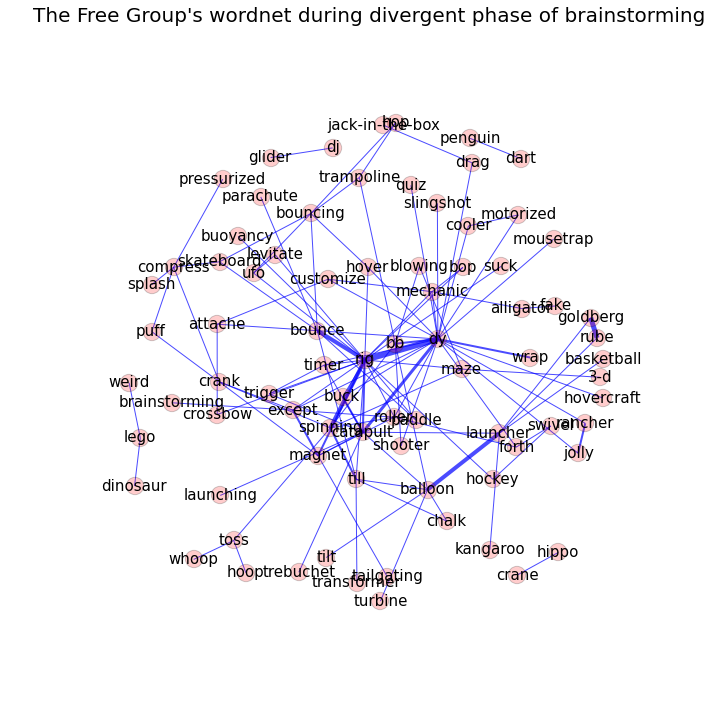

In [118]:
# Plot graph of common phrases 
from tools import draw_network
%matplotlib inline
pos = nx.spring_layout(GFree, iterations=20)
sstt="The Free Group's wordnet during divergent phase of brainstorming"
possit=draw_network(GFree,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


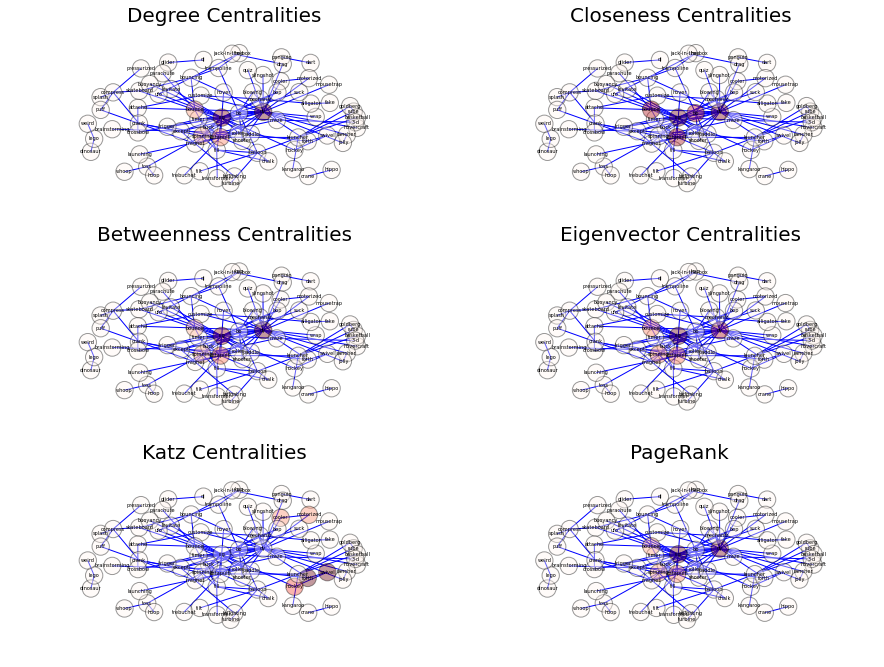

In [119]:
# Compute centralities of cmmon phrases in the graph of the divergent process

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5,
                                   figsi=(15, 15), ealpha=1, vals=True)

ERROR: Line magic function `%autoreload` not found.
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


Number of communities of  The Free Group's wordnet during divergent phase of brainstorming  =  12
Community partition of  The Free Group's wordnet during divergent phase of brainstorming :
[['splash', 'hockey', 'crank', 'brainstorming', 'pressurized', 'roller', 'skateboard', 'except', 'forth', 'magnet', 'tailgating', 'puff', 'swivel', 'compress'], ['rube', 'balloon', 'chalk', 'kangaroo', 'turbine', 'tilt', 'launcher', 'goldberg', 'basketball'], ['suck', 'till', 'rig', 'buoyancy', 'spinning', 'blowing', '3-d', 'paddle', 'maze', 'parachute', 'bounce', 'transformer'], ['shooter', 'hovercraft', 'slingshot', 'dy', 'bb', 'jolly', 'cooler', 'drag', 'wrap', 'jack-in-the-box', 'mousetrap', 'motorized', 'rancher', 'quiz'], ['fake', 'alligator', 'customize', 'mechanic', 'crossbow', 'attache', 'bop'], ['penguin', 'dart'], ['toss', 'whoop', 'hoop'], ['trebuchet', 'trigger', 'launching', 'timer', 'buck', 'catapult'], ['glider', 'dj'], ['hover', 'trampoline', 'bouncing', 'ufo', 'hop', 'levitate'], ['

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


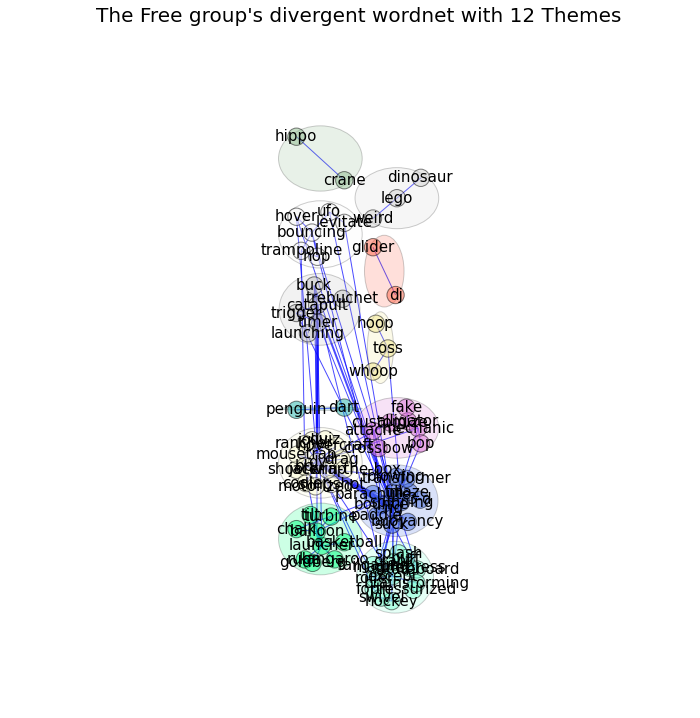

In [120]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}

sstta="The Free group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


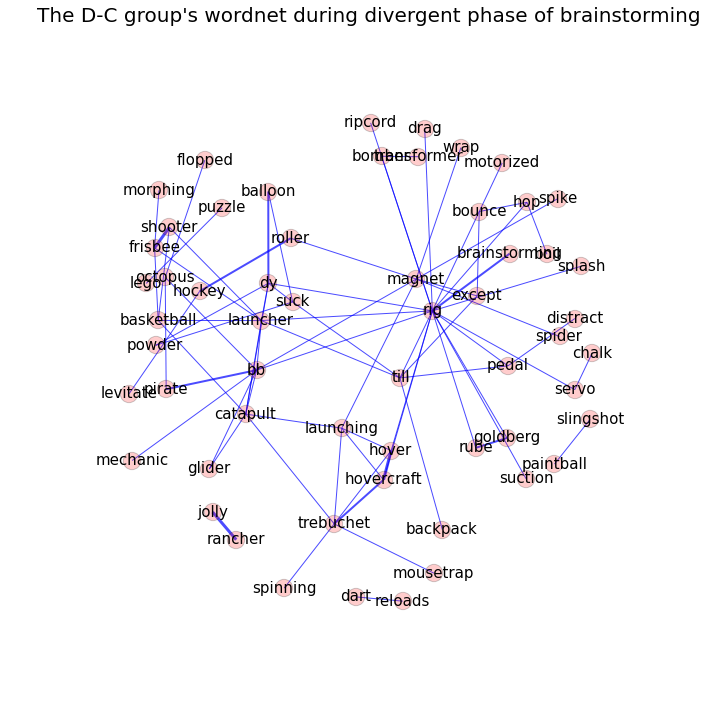

In [121]:
# Plot graph of common phrases in Team A's convergent phase
from tools import draw_network
pos = nx.spring_layout(GDC, iterations=20)
sstt="The D-C group's wordnet during divergent phase of brainstorming"
possit=draw_network(GDC,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.7,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


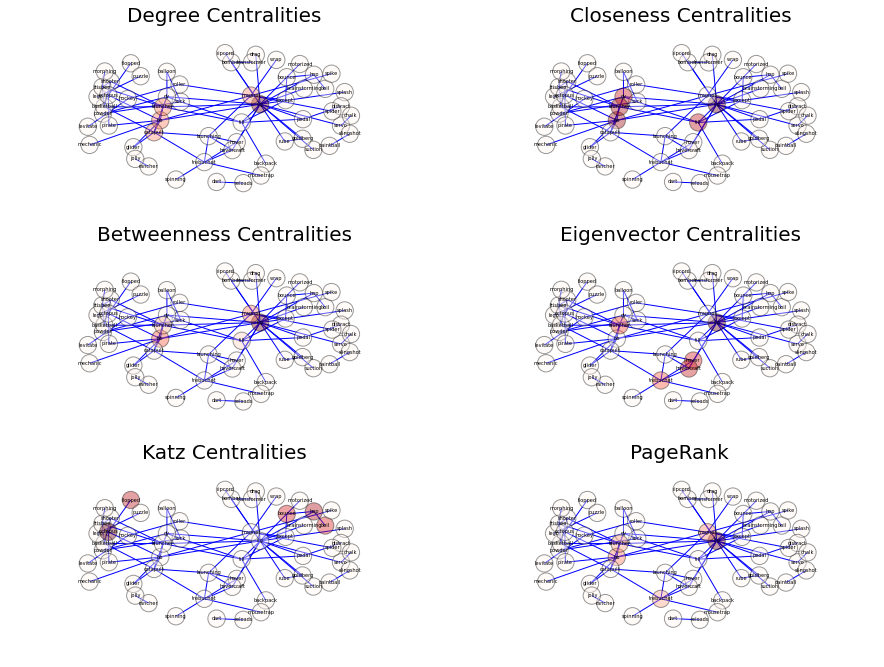

In [122]:
# Compute centralities of cmmon phrases in the graph of the divergent process

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GDC, pos, withLabels=True,labfs=5,
                                   figsi=(15, 15), ealpha=1, vals=True)

ERROR: Line magic function `%autoreload` not found.
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


Number of communities of  The D-C group's wordnet during divergent phase of brainstorming  =  10
Community partition of  The D-C group's wordnet during divergent phase of brainstorming :
[['boil', 'spike', 'roller', 'hop', 'hockey', 'except', 'wrap', 'magnet', 'bounce', 'spider', 'levitate'], ['splash', 'servo', 'rig', 'drag', 'suction', 'rube', 'chalk', 'goldberg', 'transformer', 'motorized', 'bomber', 'ripcord', 'brainstorming'], ['suck', 'distract', 'powder', 'till', 'dy', 'pedal', 'balloon', 'backpack'], ['shooter', 'frisbee', 'basketball', 'morphing', 'launcher'], ['reloads', 'dart'], ['glider', 'flopped', 'bb', 'pirate', 'mechanic', 'octopus', 'catapult'], ['trebuchet', 'hover', 'hovercraft', 'spinning', 'mousetrap', 'launching'], ['lego', 'puzzle'], ['paintball', 'slingshot'], ['rancher', 'jolly']]
Community modularity of The D-C group's wordnet during divergent phase of brainstorming  =  0.6383333333333333


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


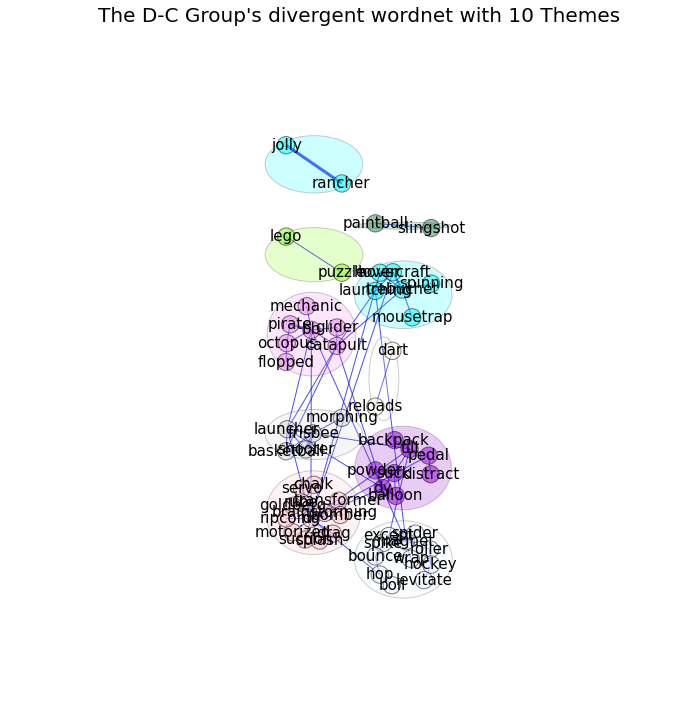

In [123]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GDC, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}

sstta="The D-C Group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GDC,GDC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


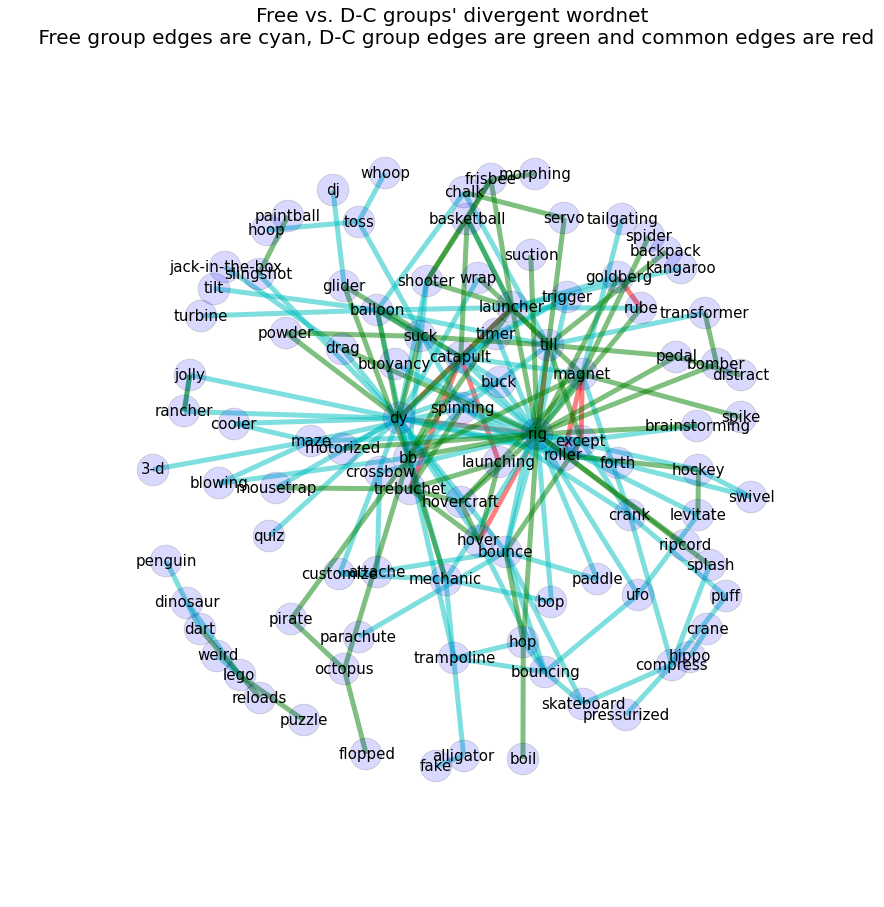

In [124]:
# Plotting the Free brainstorming group vs. the Divergent-Convergent brainstorming group's wordnet

G = nx.Graph()
G.add_edges_from(GFree.edges())
G.add_edges_from(GDC.edges())
pos=nx.spring_layout(G)
# pos=nx.spring_layout(G)
sstt="Free vs. D-C groups' divergent wordnet \n Free group edges are cyan, D-C group edges are green and common edges are red"
plt.figure(figsize=(15,15))
common_edges=set(GFree.edges()).intersection(set(GDC.edges()))
HCandBSedges = list(common_edges)
Cedges=set(GFree.edges()).difference(set(GDC.edges()))
HCedges = list(Cedges)
Sedges=set(GDC.edges()).difference(set(GFree.edges()))
BSedges = list(Sedges)
nx.draw_networkx_nodes(G,pos,withLabels=True,node_color='b',node_size=1000,alpha=0.15)
nx.draw_networkx_edges(G,pos,edgelist=HCandBSedges,width=5,alpha=0.5,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=HCedges,width=5,alpha=0.5,edge_color='c')
nx.draw_networkx_edges(G,pos,edgelist=BSedges,width=5,alpha=0.5,edge_color='g')
nx.draw_networkx_labels(G,pos=pos,font_size=15)
plt.title(sstt,fontsize=20)
kk=plt.axis('off')